<p><font size="6"><b> CASE - Bike count data</b></font></p>


> *Data wrangling in Python*  
> *November, 2020*
>
> *© 2020, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

<img src="https://static.nieuwsblad.be/Assets/Images_Upload/2014/04/17/57b8f34e-5042-11e2-80ee-5d1d7b74455f_original.jpg.h380.jpg.568.jpg?maxheight=460&maxwidth=638&scale=both">

In this case study, we will make use of the freely available bike count data of the city of Ghent (Belgium). At the Coupure Links, next to the Faculty of Bioscience Engineering, a counter keeps track of the number of passing cyclists in both directions.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Reading and processing the data

## Read csv data

The data were previously available on the open data portal of the city, and we downloaded them in the CSV format, and provided the original file as `data/fietstellingencoupure.csv`. 

This dataset contains the historical data of the bike counters, and consists of the following columns:

- The first column `datum` is the date, in `dd/mm/yy` format
- The second column `tijd` is the time of the day, in `hh:mm` format
- The third and fourth column `ri Centrum` and `ri Mariakerke` are the counts at that point in time (counts between this timestamp and the previous)

<div class="alert alert-success">

**EXERCISE**

- Read the csv file from the url into a DataFrame `df`, the delimiter of the data is `;`
- Inspect the first and last 5 rows, and check the number of observations
- Inspect the data types of the different columns

<details><summary>Hints</summary>

- With the cursor on a function, you can combine the SHIFT + TAB keystrokes to see the documentation of a function.
- Both the `sep` and `delimiter` argument will work to define the delimiter.
- Methods like `head`/`tail` have round brackets `()`, attributes like `dtypes` not.

</details>    
    
</div>

In [2]:
df = pd.read_csv("data/fietstellingencoupure.csv", sep=';')

In [3]:
df.head()

,datum,tijd,ri Centrum,ri Mariakerke
0,14/07/2011,17:44,21,46
1,14/07/2011,17:59,17,60
2,14/07/2011,18:14,13,48
3,14/07/2011,18:29,22,48
4,14/07/2011,18:44,15,51


In [4]:
df.tail()

,datum,tijd,ri Centrum,ri Mariakerke
191442,18/01/2017,22:54,16,32
191443,18/01/2017,23:09,8,22
191444,18/01/2017,23:24,10,29
191445,18/01/2017,23:39,11,31
191446,18/01/2017,23:54,12,19


In [5]:
len(df)

191447

In [6]:
df.dtypes

datum            object
tijd             object
ri Centrum        int64
ri Mariakerke     int64
dtype: object

## Data processing

As explained above, the first and second column (respectively `datum` and `tijd`) indicate the date and hour of the day. To obtain a time series, we have to combine those two columns into one series of actual datetime values. 

<div class="alert alert-success">

**EXERCISE**

Preprocess the data:

* Combine the 'datum' and 'tijd' columns into one Pandas Series of string datetime values, call this new variable `combined`.
* Parse the string datetime values to datetime objects.
* Set the resulting datetime column as the index of the `df` DataFrame.
* Remove the original 'datum' and 'tijd' columns using the `drop` method, and call the new dataframe `df2`.
* Rename the columns in the DataFrame 'ri Centrum', 'ri Mariakerke' to resp. 'direction_centre', 'direction_mariakerke' using the `rename` method.

<details><summary>Hints</summary>

- Concatenating strings can be done with the addition operation `+`.
- When converting strings to a datetime with `pd.to_datetime`, specifying the format will make the conversion a lot faster.
- `drop` can remove both rows and columns using the names of the index or column name. Make sure to define `columns=` argument to remove columns.
- `rename` can be used for both rows/columns. It needs a dictionary with the current names as keys and the new names as values. 

</details>    

In [7]:
combined = df['datum'] + ' ' + df['tijd']
combined.head()

0    14/07/2011 17:44
1    14/07/2011 17:59
2    14/07/2011 18:14
3    14/07/2011 18:29
4    14/07/2011 18:44
dtype: object

In [8]:
df.index = pd.to_datetime(combined, format="%d/%m/%Y %H:%M")

In [9]:
df2 = df.drop(columns=['datum', 'tijd'])

In [10]:
df2 = df2.rename(columns={'ri Centrum': 'direction_centre', 
                          'ri Mariakerke':'direction_mariakerke'})

In [11]:
df2.head()

,direction_centre,direction_mariakerke
2011-07-14 17:44:00,21,46
2011-07-14 17:59:00,17,60
2011-07-14 18:14:00,13,48
2011-07-14 18:29:00,22,48
2011-07-14 18:44:00,15,51


Having the data available with an interpreted datetime, provides us the possibility of having time aware plotting:

<AxesSubplot:>

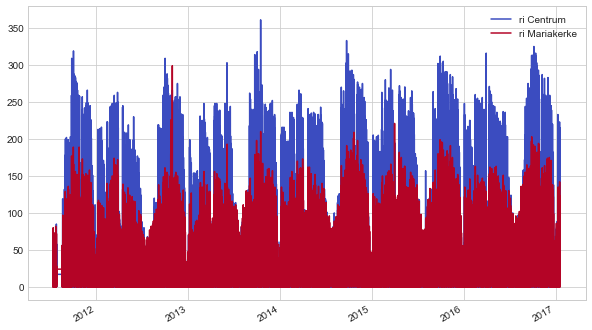

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(colormap='coolwarm', ax=ax)

<div class="alert alert-warning">

 <b>Remark</b>: Interpretation of the dates with and without predefined date format.

</div>

When we just want to interpret the dates, without specifying how the dates are formatted, Pandas makes an attempt as good as possible:

In [13]:
combined = df['datum'] + ' ' + df['tijd']

In [14]:
%timeit -n 1 -r 1 pd.to_datetime(combined, dayfirst=True)

21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


However, when we already know the format of the dates (and if this is consistent throughout the full dataset), we can use this information to interpret the dates:

In [15]:
%timeit pd.to_datetime(combined, format="%d/%m/%Y %H:%M")

661 ms ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-info">

 <b>Remember</b>: Whenever possible, specify the date format to interpret the dates to datetime values!

</div>

### Write the data set cleaning as a function

In order to make it easier to reuse the code for the preprocessing we have implemented, let's convert the code to a Python function:

<div class="alert alert-success">

**EXERCISE**

Write a function `process_bike_count_data(df)` that performs the processing steps as done above for an input Pandas DataFrame and returns the updated DataFrame.

<details><summary>Hints</summary>

- Want to knwo more about proper documenting your Python functions? Check out the official guide of [numpydoc](https://numpydoc.readthedocs.io/en/latest/format.html). The `Parameters` and `Returns` sections should always be explained.

</details>

In [16]:
def process_bike_count_data(df):
    """Process the provided dataframe: parse datetimes and rename columns.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame as read from the raw `fietstellingen`, 
        containing the `datum`, `tijd`, `ri Centrum` 
        and `ri Mariakerke` columns.
        
    Returns
    -------
    df2 : pandas.DataFrame
        DataFrame with the datetime info as index and the 
        `direction_centre` and `direction_mariakerke` columns 
        with the counts.
    """
    df.index = pd.to_datetime(df['datum'] + ' ' + df['tijd'], 
                              format="%d/%m/%Y %H:%M")
    df2 = df.drop(columns=['datum', 'tijd'])
    df2 = df2.rename(columns={'ri Centrum': 'direction_centre', 
                              'ri Mariakerke':'direction_mariakerke'})
    return df2

In [17]:
df_raw = pd.read_csv("data/fietstellingencoupure.csv", sep=';')
df_preprocessed = process_bike_count_data(df_raw)
df_preprocessed.head()

,direction_centre,direction_mariakerke
2011-07-14 17:44:00,21,46
2011-07-14 17:59:00,17,60
2011-07-14 18:14:00,13,48
2011-07-14 18:29:00,22,48
2011-07-14 18:44:00,15,51


### Store our collected dataset as an interim data product

As we finished our data-collection step, we want to save this result as an interim data output of our small investigation. As such, we do not have to re-download all the files each time something went wrong, but can restart from our interim step.

In [18]:
df_preprocessed.to_csv("bike_count_interim.csv")

## Data exploration and analysis

We now have a cleaned-up dataset of the bike counts at Coupure Links in Ghent (Belgium). Next, we want to get an impression of the characteristics and properties of the data

### Load the interim data

Reading the file in from the interim file (when you want to rerun the whole analysis on the updated online data, you would comment out this cell...)

In [19]:
df = pd.read_csv("bike_count_interim.csv", index_col=0, parse_dates=True)

### Count interval verification

The number of bikers are counted for intervals of approximately 15 minutes. But let's check if this is indeed the case. Calculate the difference between each of the consecutive values of the index. We can use the `Series.diff()` method:

In [20]:
pd.Series(df.index).diff()

0                    NaT
1        0 days 00:15:00
2        0 days 00:15:00
3        0 days 00:15:00
4        0 days 00:15:00
               ...      
191442   0 days 00:15:00
191443   0 days 00:15:00
191444   0 days 00:15:00
191445   0 days 00:15:00
191446   0 days 00:15:00
Length: 191447, dtype: timedelta64[ns]

The count of the possible intervals is of interest:

In [21]:
pd.Series(df.index).diff().value_counts()

0 days 00:15:00      191356
0 days 00:16:00           9
0 days 00:09:00           6
-1 days +23:15:00         6
0 days 00:13:00           6
0 days 00:04:00           5
0 days 01:15:00           5
0 days 00:06:00           4
0 days 00:12:00           4
0 days 00:11:00           4
0 days 00:03:00           4
0 days 00:00:00           4
0 days 00:02:00           4
0 days 00:08:00           4
0 days 00:10:00           3
0 days 00:01:00           3
0 days 00:38:00           3
0 days 00:37:00           3
0 days 00:14:00           2
0 days 00:05:00           2
0 days 01:11:00           1
0 days 00:26:00           1
0 days 00:20:00           1
0 days 00:29:00           1
0 days 01:24:00           1
0 days 00:30:00           1
0 days 06:49:00           1
0 days 00:07:00           1
20 days 21:29:00          1
dtype: int64

There are a few records that are not exactly 15min. But given it are only a few ones, we will ignore this for the current case study and just keep them for this explorative study.  

Bonus question: do you know where the values of `-1 days +23:15:01` and `01:15:00` are coming from?

In [22]:
df.describe()

,direction_centre,direction_mariakerke
count,191447.000000,191447.000000
mean,25.545237,25.338585
std,31.625619,26.903810
min,0.000000,0.000000
25%,5.000000,7.000000
50%,17.000000,17.000000
75%,34.000000,34.000000
max,361.000000,299.000000


### Quiet periods

<div class="alert alert-success">

**EXERCISE**

Create a new Pandas Series `df_both` which contains the sum of the counts of both directions.

<details><summary>Hints</summary>

- Check the purpose of the `axis` argument of the `sum` method.

</details>   

In [23]:
df_both = df.sum(axis=1)
df_both

2011-07-14 17:44:00    67
2011-07-14 17:59:00    77
2011-07-14 18:14:00    61
2011-07-14 18:29:00    70
2011-07-14 18:44:00    66
                       ..
2017-01-18 22:54:00    48
2017-01-18 23:09:00    30
2017-01-18 23:24:00    39
2017-01-18 23:39:00    42
2017-01-18 23:54:00    31
Length: 191447, dtype: int64

<div class="alert alert-success">

**EXERCISE**

Using the `df_both` from the previous exercise, create a new Series `df_quiet` which contains only those intervals for which less than 5 cyclists passed in both directions combined

<details><summary>Hints</summary>

- Use the `[]` to select data. You can use conditions (so-called _boolean indexing_) returning True/False inside the brackets.

</details>    
   

In [24]:
df_quiet = df_both[df_both < 5]

<div class="alert alert-success">

**EXERCISE**

Using the original data `df`, select only the intervals for which less than 3 cyclists passed in one or the other direction. Hence, less than 3 cyclists towards the centre or less than 3 cyclists towards Mariakerke.

<details><summary>Hints</summary>

- To combine conditions use the `|` (or) or the `&` (and) operators.
- Make sure to use `()` around each individual condition.    

</details>    
  

In [25]:
df[(df['direction_centre'] < 3) | (df['direction_mariakerke'] < 3)]

,direction_centre,direction_mariakerke
2011-07-14 23:59:00,1,13
2011-07-15 00:14:00,2,3
2011-07-15 00:44:00,2,6
2011-07-15 00:59:00,0,4
2011-07-15 01:29:00,1,10
...,...,...
2017-01-18 06:09:00,2,2
2017-01-18 06:24:00,7,1
2017-01-18 06:39:00,2,2
2017-01-18 06:54:00,8,2


### Count statistics

<div class="alert alert-success">

**EXERCISE**

What is the average number of bikers passing each 15 min?
    
<details><summary>Hints</summary>

- As the time series is already 15min level, this is just the same as taking the mean.

</details>    
    

In [26]:
df.mean()

direction_centre        25.545237
direction_mariakerke    25.338585
dtype: float64

<div class="alert alert-success">

**EXERCISE**

What is the average number of bikers passing each hour?

<details><summary>Hints</summary>

- Use `resample` to first calculate the number of bikers passing each hour. 
- `resample` requires an aggregation function that defines how to combine the values within each group (in this case all values within each hour).

</details>

In [27]:
df.resample('H').sum().mean()

direction_centre        101.113548
direction_mariakerke    100.295573
dtype: float64

<div class="alert alert-success">

**EXERCISE**

What are the 10 highest peak values observed during any of the intervals for the direction towards the centre of Ghent?

<details><summary>Hints</summary>

- Pandas provides the `nsmallest` and  `nlargest` methods to derive N smallest/largest values of a column.

</details>

In [28]:
df['direction_centre'].nlargest(10)
# alternative:
# df['direction_centre'].sort_values(ascending=False).head(10)

2013-10-16 21:38:00    361
2014-09-23 08:12:00    333
2016-10-06 09:16:00    325
2011-10-04 08:27:00    319
2013-10-03 08:49:00    318
2016-03-31 00:45:00    316
2016-10-13 09:16:00    316
2014-09-30 08:05:00    315
2013-09-23 08:34:00    314
2016-10-04 09:01:00    314
Name: direction_centre, dtype: int64

<div class="alert alert-success">

**EXERCISE**

What is the maximum number of cyclist that passed on a single day calculated on both directions combined?

<details><summary>Hints</summary>

- Combine both directions by taking the sum.
- Next, `resample` to daily values
- Get the maximum value or ask for the n largest to see the dates as well.    

</details>

In [29]:
df_both = df.sum(axis=1)

In [30]:
df_daily = df_both.resample('D').sum()

In [31]:
df_daily.max()

10770

In [32]:
df_daily.nlargest(10)

2016-09-29    10770
2016-09-28    10640
2016-09-27    10394
2014-11-05    10321
2016-10-04    10295
2012-10-30    10213
2016-10-05    10179
2016-10-06    10157
2013-06-05    10041
2016-10-13     9996
dtype: int64

2013-06-05 was supposed to be the first time more than 10,000 bikers passed on one day (and not by coincidence: http://www.nieuwsblad.be/cnt/dmf20130605_022. Although the data shows it was not actually the first time ...

### Trends as function of time

<div class="alert alert-success">

**EXERCISE**

How does the long-term trend look like? Calculate monthly sums and plot the result.

<details><summary>Hints</summary>

- The symbol for monthly resampling is `M`.
- Use the `plot` method of Pandas, which will generate a line plot of each numeric column by default.

</details>

<AxesSubplot:>

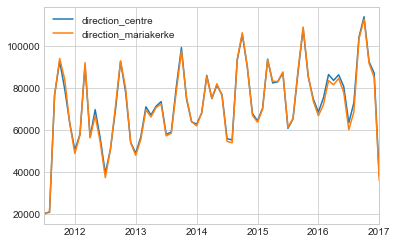

In [33]:
df_monthly = df.resample('M').sum()
df_monthly.plot()

<div class="alert alert-success">

**EXERCISE**

Let's have a look at some short term patterns. For the data of the first 3 weeks of January 2014, calculate the hourly counts and visualize them.

<details><summary>Hints</summary>

- Slicing is done using `[]`, you can use string representation of dates to select from a datetime index: e.g. `'2010-01-01':'2020-12-31'`

</details>

In [34]:
df_hourly = df.resample('H').sum()

In [35]:
df_hourly.head()

,direction_centre,direction_mariakerke
2011-07-14 17:00:00,38,106
2011-07-14 18:00:00,66,177
2011-07-14 19:00:00,62,92
2011-07-14 20:00:00,45,40
2011-07-14 21:00:00,28,30


<AxesSubplot:>

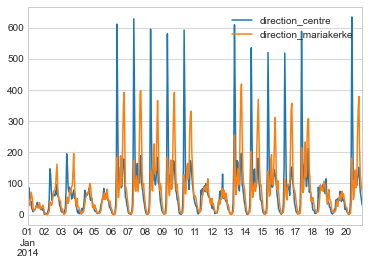

In [36]:
df_hourly['2014-01-01':'2014-01-20'].plot()

**New Year's Eve 2013-2014**

<div class="alert alert-success">

**EXERCISE**

- Select a subset of the data set from 2013-12-31 12:00:00 untill 2014-01-01 12:00:00 and assign the result to a new variable `newyear` 
- Plot the selected data `newyear`.
- Use a `rolling` function with a window of 10 values (check documentation of the function) to smooth the data of this period and make a plot of the smoothed version.

<details><summary>Hints</summary>

- Just like `resample`, `rolling` requires an aggregate statistic (e.g. mean, median,...) to combine the values within the window.

</details>

In [37]:
newyear = df["2013-12-31 12:00:00": "2014-01-01 12:00:00"]

<AxesSubplot:>

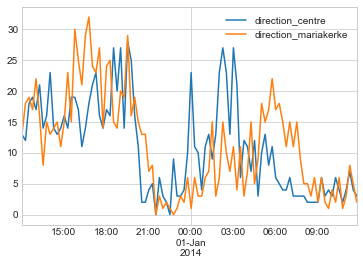

In [38]:
newyear.plot()

<AxesSubplot:>

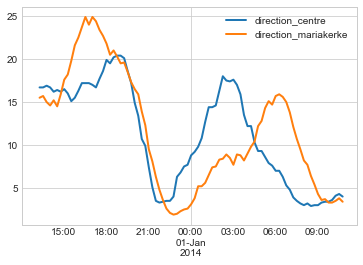

In [39]:
newyear.rolling(10, center=True).mean().plot(linewidth=2)

A more advanced usage of matplotlib to create a combined plot:

Text(0, 0.5, 'Cyclists count')

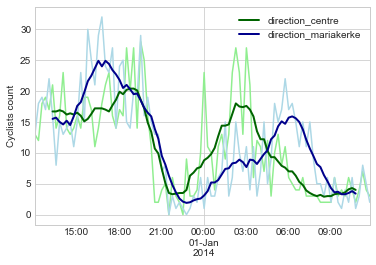

In [40]:
# A more in-detail plotting version of the graph.
fig, ax = plt.subplots()
newyear.plot(ax=ax, color=['LightGreen', 'LightBlue'], legend=False, rot=0)
newyear.rolling(10, center=True).mean().plot(linewidth=2, ax=ax, color=['DarkGreen', 'DarkBlue'], rot=0)

ax.set_xlabel('')
ax.set_ylabel('Cyclists count')

---

## The power of `groupby`...

Looking at the data in the above exercises, there seems to be clearly a:

- daily pattern
- weekly pattern
- yearly pattern

Such patterns can easily be calculated and visualized in pandas using the DatetimeIndex attributes `weekday` combined with `groupby` functionality. Below a taste of the possibilities, and we will learn about this in the proceeding notebooks:

**Weekly pattern**:

In [41]:
df_daily = df.resample('D').sum()

<AxesSubplot:>

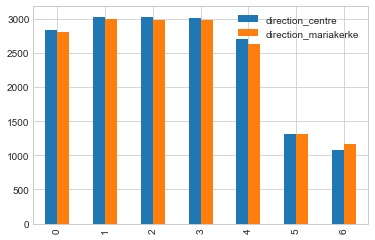

In [42]:
df_daily.groupby(df_daily.index.weekday).mean().plot(kind='bar')

**Daily pattern:**

<AxesSubplot:>

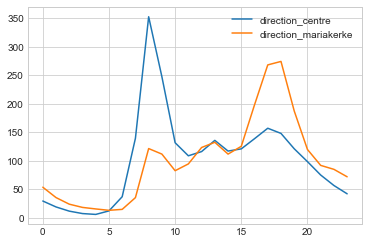

In [43]:
df_hourly.groupby(df_hourly.index.hour).mean().plot()

So the daily pattern is clearly different for both directions. In the morning more people go north, in the evening more people go south. The morning peak is also more condensed.

**Monthly pattern**

In [44]:
df_monthly = df.resample('M').sum()

In [45]:
from calendar import month_abbr 

<ipython-input-46-3ca7ef03ba99>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  xlabels = ax.set_xticklabels(list(month_abbr)[0::2]) #too lazy to write the month values yourself...


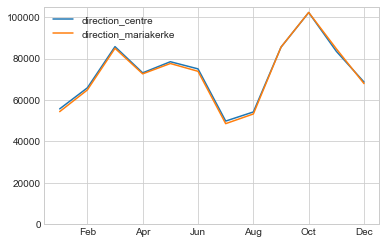

In [46]:
ax = df_monthly.groupby(df_monthly.index.month).mean().plot()
ax.set_ylim(0)
xlabels = ax.set_xticklabels(list(month_abbr)[0::2]) #too lazy to write the month values yourself...

## Acknowledgements
Thanks to the [city of Ghent](https://data.stad.gent/) for opening their data